# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [20]:
import cv2 
import gc 
import random
import torch
import torchvision 
import torchvision.models as models
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Not available, CUDA!!!  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

print('torch: ', torch.__version__, ', torchvision: ', torchvision.__version__)

CUDA is available!  Training on GPU ...
torch:  1.5.0+cu101 , torchvision:  0.6.0+cu101


In [2]:
import numpy as np
from glob import glob

local_path = '/home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/'
# load filenames for human and dog images
human_files = np.array(glob(local_path+"lfw/*/*/*"))
dog_files = np.array(glob(local_path+"dogImages/*/*/*"))
dog_files_test = np.array(glob(local_path+"dogImages/test/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


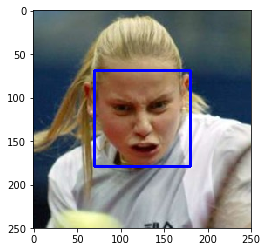

In [3]:
              
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [6]:
%%time

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Percentage of the first 100 images in human_files have a detected human face
detected_hfaces_h = [face_detector(img_path) for img_path in human_files_short]
human_perc_h = sum(detected_hfaces_h)/100    

# Percentage of the first 100 images in dog_files have a detected human face
detected_hfaces_d = [face_detector(img_path) for img_path in dog_files_short]
human_perc_d = sum(detected_hfaces_d)/100

print('+ The percentage of the first 100 images in human_files have a detected human face, ',human_perc_h)
      
      
print('+ The percentage of the first 100 images in dog_files have a detected human face, ', human_perc_d)


+ The percentage of the first 100 images in human_files have a detected human face,  0.98
+ The percentage of the first 100 images in dog_files have a detected human face,  0.16
CPU times: user 58.8 s, sys: 182 ms, total: 59 s
Wall time: 10.4 s


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if train_on_gpu:
    VGG16 = VGG16.cuda()

In [8]:
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

(688, 1024, 3)


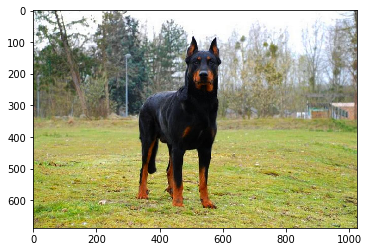

In [9]:
# Let's test a dog file
BGR_dog_img = cv2.imread(dog_files[0])
dog_img = cv2.cvtColor(BGR_dog_img, cv2.COLOR_BGR2RGB)
print(dog_img.shape)
plt.imshow(dog_img)
plt.show()

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [10]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(255), 
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    BGR_img = cv2.imread(img_path)
    RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)

    # plt.imshow(RGB_img)
    # plt.show()
    
    RGB_img = normalize(RGB_img)

    # output the image
    # print(RGB_img.shape)


    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        RGB_img = RGB_img.cuda()

    ## Return the *index* of the predicted class for that image
    # get sample outputs
    with torch.no_grad():
        output = VGG16(RGB_img.unsqueeze(0))
        torch.cuda.empty_cache()
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    gc.collect()
    
    return pred # predicted class index

/home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/dogImages/valid/071.German_shepherd_dog/German_shepherd_dog_04897.jpg


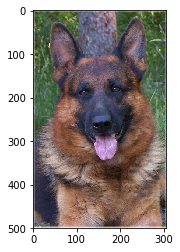

235


In [11]:
img_path = dog_files[276]
pred = VGG16_predict(img_path)
print(img_path)

BGR_img = cv2.imread(img_path)
RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)

plt.imshow(RGB_img)
plt.show()
print(pred)


In [12]:
import urllib.request, json 

imagenet_class_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

with urllib.request.urlopen(imagenet_class_url) as url:
    class_idx = json.loads(url.read().decode())
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    print(idx2label[pred])

German_shepherd


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    idx = VGG16_predict(img_path)
    return True if (151 <= idx) & (idx <= 268) else False    

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [14]:
%%time 

### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Percentage of the first 100 images in human_files have a detected human face
detected_dfaces_h = 0
for img_path in human_files_short:
    detected_dfaces_h += dog_detector(img_path) 
dog_perc_h = detected_dfaces_h/100    

# Percentage of the first 100 images in dog_files have a detected human face
detected_dfaces_d = 0 
for img_path in dog_files_short:
    detected_dfaces_d += dog_detector(img_path)
dog_perc_d = detected_dfaces_d/100

print('+ The percentage of the first 100 images in human_files have a detected human face: ', dog_perc_h)
print('+ The percentage of the first 100 images in dog_files have a detected human face: ', dog_perc_d)


+ The percentage of the first 100 images in human_files have a detected human face:  0.0
+ The percentage of the first 100 images in dog_files have a detected human face:  0.99
CPU times: user 19.6 s, sys: 1.96 s, total: 21.6 s
Wall time: 12.5 s


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
import os
from torchvision import datasets

# Define transforms for the training data and testing data
data_transforms = {
      'train': transforms.Compose([
                  transforms.RandomRotation(30),
                  transforms.RandomResizedCrop(224),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])]),

      'valid': transforms.Compose([
                  transforms.Resize(255),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])]),


      'test': transforms.Compose([
                  transforms.Resize(255),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),                                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])])
}



# set up the image folders
data_dir = local_path + 'dogImages/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                        data_transforms[x])
                  for x in ['train', 'valid', 'test']}

# prepare data loaders (combine dataset and sampler)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=6)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
print(dataset_sizes, '& Number of class names:', len(class_names))

{'train': 6680, 'valid': 835, 'test': 836} & Number of class names: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- Since we will follow the standard of ImageNet datasets to use the VGG16 model later on. The input tensor is set to (3, 224, 224), with each batch contains 32 images. Therefore, the Resize and CenterCrop transformations are applied for all the images.

- For the training data, we also do augemtation to increase the amount of data, hence,  a combination of RandomRotation, RandomResizedCrop, RandomHorizontalFlip is used.

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


(32, 3, 224, 224)


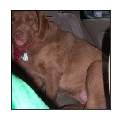

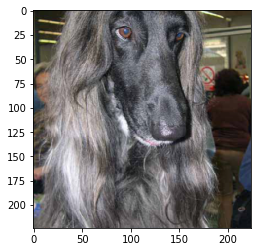

In [17]:
# obtain one batch of training images and visualise some images
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for 
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(2):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[labels[idx]])

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [18]:


# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2) 
        nn.init.xavier_uniform(self.conv1.weight)   
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=2)
        nn.init.xavier_uniform(self.conv2.weight) 
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        nn.init.xavier_uniform(self.conv3.weight) 
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(64 * 28 * 28, 1000)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1000, len(class_names))
        nn.init.kaiming_normal_(self.fc2.weight)

        # ToDo: change the drop out to 0.35 since it is still overfit 
        self.dropout = nn.Dropout(p=0.35)  


    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
#         print(x.shape)
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model_scratch.to(device)

model_scratch

cuda


Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=133, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

After tested out several CNN architectures, we arrived with the current one since we do not have a large amount of data. 

There are three Conv2d layers and  two corresponding MaxPool2d layers.  We also apply the Dropout with p=0.2 to prevent overfitting. After flatten out, we apply two other Linear layers before output the last features of length is class_names = 133.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [21]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
#optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.01)
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.3)
# Decay LR by Reduce LR On Plateau with a little patience
plateau_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_scratch, mode='max', factor=0.3, patience=4, verbose=True)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [22]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, scheduler, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # ToDo: Run the ReduceLROnPlateau scheduler next time
        scheduler.step()
        print('Epoch:', epoch,'LR:', scheduler.get_lr())
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                # print(data.shape, target.shape)
            optimizer.zero_grad()
            ## find the loss and update the model parameters accordingly
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            ## record the average training loss,
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)

            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss


        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        gc.collect()
        torch.cuda.empty_cache()
        
        ## TODO: save the model if validation loss has decreased
            
    # return trained model
    return model


In [22]:

# train the model
model_scratch = train(50, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, plateau_lr_scheduler, train_on_gpu, 'model_scratch.pt')



Validation loss decreased (inf --> 4.760346).  Saving model ...
Epoch: 1 	Training Loss: 4.843311 	Validation Loss: 4.760346
Validation loss decreased (4.760346 --> 4.639814).  Saving model ...
Epoch: 2 	Training Loss: 4.696522 	Validation Loss: 4.639814
Validation loss decreased (4.639814 --> 4.591816).  Saving model ...
Epoch: 3 	Training Loss: 4.618348 	Validation Loss: 4.591816
Validation loss decreased (4.591816 --> 4.526932).  Saving model ...
Epoch: 4 	Training Loss: 4.542754 	Validation Loss: 4.526932
Validation loss decreased (4.526932 --> 4.447917).  Saving model ...
Epoch: 5 	Training Loss: 4.493810 	Validation Loss: 4.447917
Epoch: 6 	Training Loss: 4.444402 	Validation Loss: 4.576591
Validation loss decreased (4.447917 --> 4.378165).  Saving model ...
Epoch: 7 	Training Loss: 4.307862 	Validation Loss: 4.378165
Validation loss decreased (4.378165 --> 4.361454).  Saving model ...
Epoch: 8 	Training Loss: 4.260232 	Validation Loss: 4.361454
Validation loss decreased (4.36145

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print(f'Test Accuracy: {100. * correct / total}')

In [25]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

In [26]:
# call test function    
test(dataloaders, model_scratch, criterion_scratch, train_on_gpu)

Test Loss: 3.693786

Test Accuracy: 15.789473684210526


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [27]:


## TODO: Specify model architecture 
model_transfer = models.resnet18(pretrained=True)

# print out the model structure
print(model_transfer)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False

In [29]:
n_inputs = model_transfer.fc.in_features

# add last linear layer (n_inputs -> 133 classes of dog breeds)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(class_names))

model_transfer.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    model_transfer = model_transfer.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer.fc.out_features)



133


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

- We use the pretrained resnet18 model for our transfer learning task. The requires_grad for these layers are not required to reduce the amount of computation. Note that the new Linear layer transform the last layers into the output of class_names = 133 length.  

- Since the resnet18 architecture is quite powerful, it should be able to detect most of the characteristics of objects in Imagenet, we just need to add the last layers on top to train a good dog breeds' model.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [30]:
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=10, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [31]:
# train the model
model_transfer =  train(10, dataloaders, model_transfer,                     optimizer_transfer, criterion_transfer, exp_lr_scheduler, train_on_gpu, 'model_transfer.pt')


Validation loss decreased (inf --> 3.968263).  Saving model ...
Epoch: 1 	Training Loss: 4.533634 	Validation Loss: 3.968263
Validation loss decreased (3.968263 --> 3.184882).  Saving model ...
Epoch: 2 	Training Loss: 3.625476 	Validation Loss: 3.184882
Validation loss decreased (3.184882 --> 2.749128).  Saving model ...
Epoch: 3 	Training Loss: 3.021551 	Validation Loss: 2.749128
Validation loss decreased (2.749128 --> 2.369039).  Saving model ...
Epoch: 4 	Training Loss: 2.592895 	Validation Loss: 2.369039
Validation loss decreased (2.369039 --> 2.061485).  Saving model ...
Epoch: 5 	Training Loss: 2.314353 	Validation Loss: 2.061485
Validation loss decreased (2.061485 --> 2.006227).  Saving model ...
Epoch: 6 	Training Loss: 2.115494 	Validation Loss: 2.006227
Validation loss decreased (2.006227 --> 1.801034).  Saving model ...
Epoch: 7 	Training Loss: 1.950523 	Validation Loss: 1.801034
Validation loss decreased (1.801034 --> 1.716199).  Saving model ...
Epoch: 8 	Training Loss: 1

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(dataloaders, model_transfer, criterion_transfer, train_on_gpu)

Test Loss: 1.033611

Test Accuracy: 78.82775119617224


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [33]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

idx2label = [class_names[k] for k in range(len(class_names))]
    

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.


def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    BGR_img = cv2.imread(img_path)
    RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
    
    RGB_img = normalize(RGB_img)

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        RGB_img = RGB_img.cuda()

    ## Return the *index* of the predicted class for that image
    # get sample outputs
    with torch.no_grad():
        output = model_transfer(RGB_img.unsqueeze(0))
        torch.cuda.empty_cache()
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    gc.collect()
    
    return idx2label[pred] # predicted class index

In [35]:
print(dog_files_test[179])
predict_breed_transfer(dog_files_test[179])

/home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/dogImages/test/059.Doberman_pinscher/Doberman_pinscher_04169.jpg


'German pinscher'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [36]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path):
        print(f"It's a dog of type {predict_breed_transfer(img_path)}")
    elif face_detector(img_path):
        print(f"That's a human, but looks like a {predict_breed_transfer(img_path)}")
    else:
        print('Opp! Something else.')    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

At the moment, we apply the face_cascade function for human tection and the previous transfer learning model for dog detection. Therefore the results might perform very well. However, there are several methods we can use to improve the algorithm.

+ Build a better human face detector using CNN with higher accuracy than the face_cascade.
+ Create a model with three classes of human face, dog face and others to improve the whole process, instead of combined different models together
+ Add more data for our dog and human dataset, tune the hyper-parameters of these models with different infrastructure to improve the model output.

******** /home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/lfw/lfw/Duane_Barber/Duane_Barber_0001.jpg ************
That's a human, but looks like a Basenji


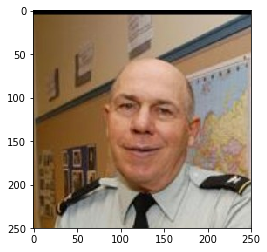

******** /home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/lfw/lfw/Stacey_Dales-Schuman/Stacey_Dales-Schuman_0001.jpg ************
That's a human, but looks like a Dogue de bordeaux


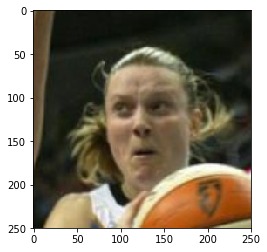

******** /home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/lfw/lfw/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg ************
That's a human, but looks like a Pharaoh hound


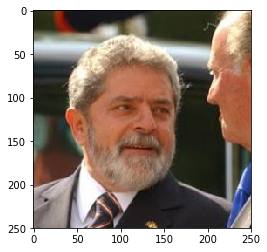

******** /home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/dogImages/test/049.Chinese_crested/Chinese_crested_03508.jpg ************
It's a dog of type Chinese crested


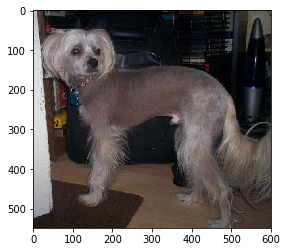

******** /home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/dogImages/test/125.Portuguese_water_dog/Portuguese_water_dog_07975.jpg ************
It's a dog of type Black russian terrier


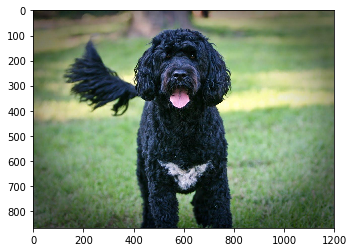

******** /home/philip/Shares/local/philip/ML_Data/Udacity/DeepLearning/dogbreed/dogImages/test/132.Xoloitzcuintli/Xoloitzcuintli_08312.jpg ************
It's a dog of type Xoloitzcuintli


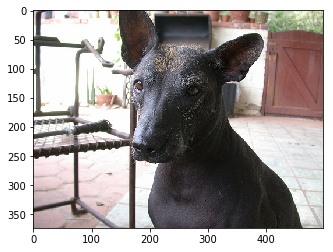

In [37]:
##  Execute your algorithm from Step 6 on at least 6 random images in test set.

for file in np.hstack(([random.choice(human_files) for i in range(3)], [random.choice(dog_files_test) for i in range(3)])):
    print(f'******** {file} ************')
    BGR_img = cv2.imread(file)
    img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    run_app(file)
    plt.show()